### 1. Título y Descripción del Proyecto

Este notebook utiliza Transfer Learning con un modelo preentrenado de TensorFlow para detectar células infectadas con malaria a partir de imágenes. Usaremos el modelo Xception, preentrenado en ImageNet, y lo ajustaremos para nuestra tarea de clasificación binaria.


### 2. Importación de Librerías

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios de datos
train_dir = '/Users/ignaciocarrenoromero/PROYECTOS PERSONALES/MALARIA-DETECTOR/training_models/data/Train'
test_dir = '/Users/ignaciocarrenoromero/PROYECTOS PERSONALES/MALARIA-DETECTOR/training_models/data/Test'
val_dir = '/Users/ignaciocarrenoromero/PROYECTOS PERSONALES/MALARIA-DETECTOR/training_models/data/Val'

# Parámetros
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Generadores de datos
'''
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
                                   
'''


# Sin data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 22047 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


In [6]:
count_class_unique = test_generator.classes
count_class = dict(zip(*np.unique(count_class_unique, return_counts=True)))
print(count_class)


{0: 7952, 1: 7880}


### 4. Construcción del Modelo Usando Transfer Learning

### 5. Entrenamiento del Modelo

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Cargar el modelo base preentrenado ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                            input_shape=(150, 150, 3),
                                            include_top=False)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False



model = models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

# Compilar el modelo con un optimizador ajustado
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,349,441 (100.52 MB)

 Trainable params: 2,758,145 (10.52 MB)

 Non-trainable params: 23,591,296 (89.99 MB)

In [12]:
# Callbacks
EPOCHS = 20

# 1. Guardar el modelo en cada época con el número de época en el nombre del archivo
epoch_checkpoint_cb = ModelCheckpoint('model_epoch_{epoch:02d}.keras', 
                             save_best_only=False, 
                                      monitor='val_loss', 
                                      mode='min', 
                                      verbose=1)

# 2. Guardar el mejor modelo basado en la métrica de validación
best_checkpoint_cb = ModelCheckpoint('best_model.keras', 
                                     save_best_only=True, 
                                     monitor='val_loss', 
                                     mode='min', 
                                     verbose=1)

# 3. Detener el entrenamiento si la métrica de validación no mejora después de 'n' épocas
early_stopping_cb = EarlyStopping(monitor='val_loss', 
                                  patience=10, 
                                  restore_best_weights=True, 
                                  verbose=1)

# 4. Reducir la tasa de aprendizaje si la métrica de validación no mejora
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.2, 
                                 patience=5, 
                                 min_lr=1e-6, 
                                 verbose=1)

# Lista de callbacks
callbacks = [epoch_checkpoint_cb, best_checkpoint_cb, early_stopping_cb, reduce_lr_cb]

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/20


/Users/ignaciocarrenoromero/Library/Caches/pypoetry/virtualenvs/malaria-detector-ii4fgasz-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - auc_1: 0.6367 - binary_accuracy: 0.6002 - loss: 2.4280
Epoch 1: saving model to model_epoch_01.keras

Epoch 1: val_loss improved from inf to 1.44410, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 226s 324ms/step - auc_1: 0.6367 - binary_accuracy: 0.6003 - loss: 2.4274 - val_auc_1: 0.7613 - val_binary_accuracy: 0.6874 - val_loss: 1.4441 - learning_rate: 1.0000e-04
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - auc_1: 0.7037 - binary_accuracy: 0.6514 - loss: 1.5609
Epoch 2: saving model to model_epoch_02.keras

Epoch 2: val_loss improved from 1.44410 to 1.38476, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 226s 328ms/step - auc_1: 0.7037 - binary_accuracy: 0.6514 - loss: 1.5608 - val_auc_1: 0.7822 - val_binary_accuracy: 0.6932 - val_loss: 1.3848 - learning_rate: 1.0000e-04
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - auc_1: 0.7307 - binary_accuracy: 0.6746 - loss: 1.4532
Epoch 3: saving mode

### Disponemos de otros modelos preentrenados en la página de TensorFlow Hub

Puedes utilizar diferentes modelos preentrenados disponibles en [TensorFlow Hub](https://www.tensorflow.org/hub). A continuación, se muestran algunas URLs de modelos preentrenados que pueden ser utilizados como extractores de características:

```python
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
model_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


### 6. Evaluación del Modelo

### Evaluación del Modelo: Métricas Relevantes

#### Accuracy, Loss y AUC

In [13]:
# Evaluar el modelo en el conjunto de prueba
metrics = model.evaluate(test_generator)

# Acceder a las métricas
test_loss = metrics[0]
test_accuracy = metrics[1]
test_auc = metrics[2]

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')



495/495 ━━━━━━━━━━━━━━━━━━━━ 132s 266ms/step - auc_1: 0.8842 - binary_accuracy: 0.7915 - loss: 0.8151
Test Loss: 0.8141326904296875
Test Accuracy: 0.7951617240905762
Test AUC: 0.8849751949310303


### Matriz de confusión

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

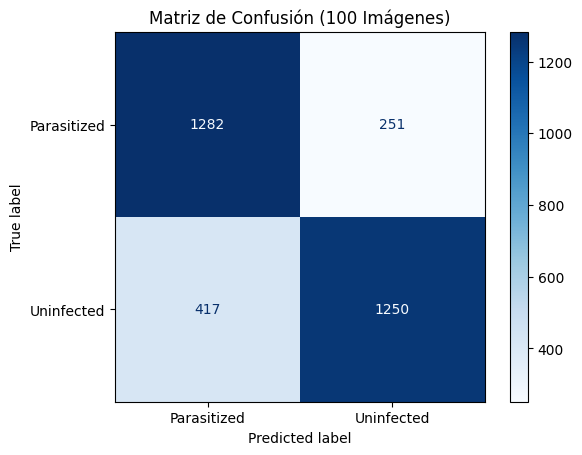

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


y_pred = []
y_true = []

# Restablecer el generador de prueba para asegurarse de que comience desde el principio
test_generator.reset()

# Obtener un subconjunto de 100 imágenes del generador de prueba
for i in range(100):
    x_batch, y_batch = next(test_generator)  # Obtener el batch de imágenes y etiquetas
    y_pred_prob = model.predict(x_batch)
    
    # Convertir las probabilidades predichas en clases (0 o 1)
    y_pred_batch = (y_pred_prob > 0.5).astype("int32").flatten()  # Si es binario
    
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch.flatten())  


y_pred = np.array(y_pred)
y_true = np.array(y_true)


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (100 Imágenes)')
plt.show()


####  AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) y área bajo la curva Precision-Recall


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

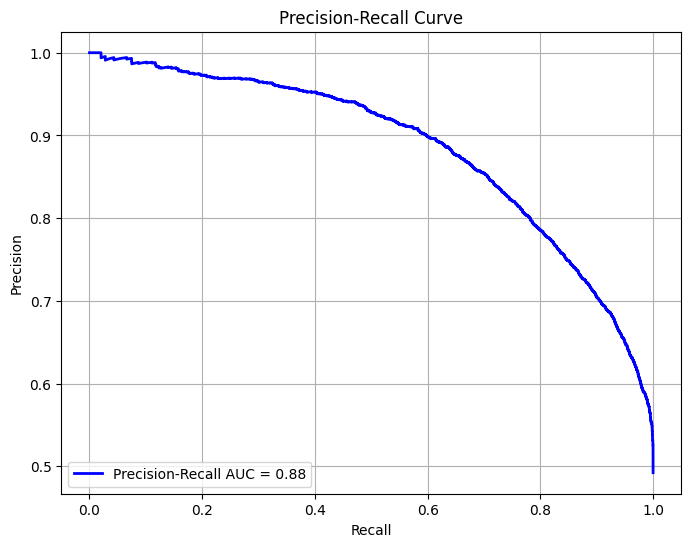

In [15]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt


y_pred_prob = []
y_true = []

# Obtener todas las predicciones y etiquetas verdaderas del generador
for i in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_prob_batch = model.predict(x_batch).flatten()  # Asegurarse de que esté en la forma correcta
    y_pred_prob.extend(y_pred_prob_batch)
    y_true.extend(y_batch.flatten())


y_pred_prob = np.array(y_pred_prob)
y_true = np.array(y_true)

print(f'Longitud de y_true: {len(y_true)}')
print(f'Longitud de y_pred_prob: {len(y_pred_prob)}')

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred_prob)
print(f'AUC-ROC: {auc_roc}')

# Calcular Precisión-Recall
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

# Calcular el área bajo la curva Precision-Recall
auc_pr = auc(recall, precision)
print(f'AUC-Precision-Recall: {auc_pr}')

# Graficar Precision vs. Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
